In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
 #       print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_classes_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [5]:
sample_submission_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test1[0])+float(test2[0])

In [33]:
test2

['20522']

In [7]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
image_number =10
img = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))

In [9]:
img.shape

(256, 256, 3)

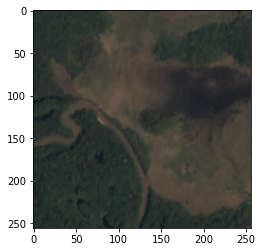

In [10]:
plt.imshow(img)

In [11]:
train_classes_df[train_classes_df['image_name'] == 'train_10']

,image_name,tags
10,train_10,agriculture clear primary slash_burn water


In [12]:
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [13]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['cultivation', 'road', 'partly_cloudy', 'habitation', 'cloudy', 'haze', 'artisinal_mine', 'selective_logging', 'agriculture', 'water', 'conventional_mine', 'bare_ground', 'blow_down', 'clear', 'slash_burn', 'primary', 'blooming']


In [14]:
len(unique_labels)

17

In [15]:
assert len(train_classes['image_name'].unique()) == train_classes.shape[0]

In [16]:
# let's do one hot encoding (vectorize) the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,cultivation,road,partly_cloudy,habitation,cloudy,haze,artisinal_mine,selective_logging,agriculture,water,conventional_mine,bare_ground,blow_down,clear,slash_burn,primary,blooming
0,train_0.jpg,haze primary,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [17]:
import tensorflow as tf

In [18]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [19]:
tf.keras.preprocessing.image.ImageDataGenerator.flow_from_dataframe?

In [20]:
# X is an iterable, It contains 317 batches, each batch contains 128 images and labels because 
#40479 / 128 is 316 remainder 31 each image is of shape (128, 128, 3), each label is of shape (17, )

# let's abitrarily view an image
x109 = X[0][0][109] # first batch, images, 109th image
y109 = X[0][1][109] # first batch, labels, 109th label
print("each image's shape is {}".format(x109.shape))
print("each label's shape is {}".format(y109.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 317 batches
each batch has 128 images/labels
40479/128 is 316.24, so the last batch will have 31 images/labels


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [23]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [24]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=3, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-2)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [25]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [26]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [27]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [28]:
step_train_size+step_val_size

317

turn on GPU

In [29]:
model1 = build_model() # building a sequential model for training

# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=2, callbacks=[save_best_check_point])

Epoch 1/2
253/253 [==============================] - 169s 668ms/step - loss: 50.6926 - multi_label_acc: 0.8548 - fbeta: 0.6037 - val_loss: 2.0273 - val_multi_label_acc: 0.9026 - val_fbeta: 0.6794
Epoch 2/2
253/253 [==============================] - 106s 418ms/step - loss: 10.9131 - multi_label_acc: 0.8625 - fbeta: 0.6153 - val_loss: 3.5188 - val_multi_label_acc: 0.8994 - val_fbeta: 0.6976


In [30]:
model2 = build_model() # building a sequential model for testing

#loading in the weights of the trained model
model2.load_weights('best_model.hdf5')

In [31]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [34]:
# selecting the first 40669 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [35]:
test1_df.shape

(40669, 1)

In [36]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [37]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

318/318 [==============================] - 163s 512ms/step


In [38]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,agriculture clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,agriculture primary
3,test_3.jpg,agriculture clear primary
4,test_4.jpg,agriculture primary


In [39]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [44]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [45]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

161/161 [==============================] - 52s 324ms/step


In [46]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,cultivation road artisinal_mine agriculture wa...
2,file_10.jpg,agriculture primary
3,file_100.jpg,agriculture clear primary
4,file_1000.jpg,clear primary


In [47]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,agriculture clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,agriculture primary
3,test_3.jpg,agriculture clear primary
4,test_4.jpg,agriculture primary


In [48]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [49]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,agriculture clear primary
1,test_1,clear primary
2,test_2,agriculture primary
3,test_3,agriculture clear primary
4,test_4,agriculture primary


In [50]:
final_result.to_csv('seventh_submission.csv', index=False) # saving the predictions